In [8]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import tensorflow as tf

tf.config.run_functions_eagerly(True)

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

print(tf.__version__)



2.11.0


In [3]:
class SSPCAB(tf.keras.layers.Layer):
    def __init__(self, kernel_dim, dilation, filters, reduction_ratio=8, name=None):
        super(SSPCAB, self).__init__(name=name)
        
        self.kernel_dim = kernel_dim
        self.dilation = dilation
        self.filters = filters
        self.reduction_ratio = reduction_ratio
        
        self.pad = kernel_dim + dilation
        self.border_input = kernel_dim + 2*dilation + 1
        
        self.sspcab_1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_dim, activation=tf.nn.relu, name=f'{name}_1')
        
        self.sspcab_3 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_dim, activation=tf.nn.relu, name=f'{name}_3')
        
        self.sspcab_7 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_dim, activation=tf.nn.relu, name=f'{name}_7')
        
        self.sspcab_9 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_dim, activation=tf.nn.relu, name=f'{name}_9')
        
    def se_block(self, input_x, in_channels, ratio):
        squeeze = tf.reduce_mean(input_x, axis=[1, 2])
        
        excitation = tf.keras.layers.Dense(use_bias=True, units=in_channels / ratio, name='sspcab_se_1')(squeeze)
        excitation = tf.nn.relu(excitation)
        excitation = tf.keras.layers.Dense(use_bias=True, units=in_channels, name='sspcab_se_2')(excitation)
        excitation = tf.nn.sigmoid(excitation)

        excitation = tf.reshape(excitation, [-1, 1, 1, in_channels])
        scale = input_x * excitation
        
        return scale
        
        
    def call(self, inputs, *args, **kwargs):
        sspcab_input = tf.pad(inputs, tf.constant([[0, 0], [self.pad, self.pad], [self.pad, self.pad], [0, 0]]), "REFLECT")
        
        out_1 = self.sspcab_1(sspcab_input[:, :-self.border_input, :-self.border_input, :])
        out_3 = self.sspcab_3(sspcab_input[:, self.border_input:, :-self.border_input, :])
        out_7 = self.sspcab_7(sspcab_input[:, :-self.border_input, self.border_input:, :])
        out_9 = self.sspcab_9(sspcab_input[:, self.border_input:, self.border_input:, :])
        
        sspcab_out = out_1 + out_3 + out_7 + out_9

        se_out = self.se_block(sspcab_out, self.filters, self.reduction_ratio)
        
        cost_sspcab = tf.square(inputs - se_out)
        loss = 0.1 * tf.reduce_mean(cost_sspcab)
                
        self.add_loss(loss)

        return se_out

In [4]:
#Size of our input images
SIZE = 128

from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'datasets/mvtecad/hazelnut/train/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'datasets/mvtecad/hazelnut/test/good/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    'datasets/mvtecad/hazelnut/test/defective/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 391 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 70 images belonging to 4 classes.


In [5]:
model = Sequential()

# Encoder 
"""
Each encoder is composed of three convolutional (conv)
layers, each followed by a max-pooling layer with a filter
size of 2 × 2 applied at a stride of 2. The conv layers are
formed of 3 × 3 filters. Each conv layer is followed by
Rectified Linear Units (ReLU) [70] as the activation function.
The first two conv layers consist of 32 filters, while the
third layer consists of 16 filters. The latent representation
is composed of 16 activation maps of size 8 × 8.
"""

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same', strides=2))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))

# Decoder
"""
Each decoder starts with an upsampling layer, increasing
the spatial support of the activation maps by a factor of
2×. The upsampling operation is based on nearest neighbor
interpolation. After upsampling, we apply a conv layer with
16 filters of 3 × 3. The first upsampling and conv block
is followed by another two upsampling and conv blocks.
The last conv layer of an appearance decoder is formed of
a single conv filter, while the last conv layer of a motion
decoder is formed of two filters. In both cases, the number
of filters in the last conv layer is chosen such that the size of
the output matches the size of the input
"""
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(SSPCAB(name='sspcab', filters=64, kernel_dim=1, dilation=1, reduction_ratio=8))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

# 
# model.add(SSPCAB(name='sspcab', filters=3, kernel_dim=1, dilation=1, reduction_ratio=8))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 16)       0

In [9]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 390 // batch_size,
        epochs=20,
        shuffle = True)


Epoch 1/20


c:\Users\AzqzPC\Desktop\Files\School\CIS490I\PaperReport\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 [==============================] - 38s 3s/step - loss: 0.0654 - mse: 0.0606
Epoch 2/20
12/12 [==============================] - 37s 3s/step - loss: 0.0227 - mse: 0.0203
Epoch 3/20
12/12 [==============================] - 37s 3s/step - loss: 0.0080 - mse: 0.0065
Epoch 4/20
12/12 [==============================] - 37s 3s/step - loss: 0.0062 - mse: 0.0053
Epoch 5/20
12/12 [==============================] - 37s 3s/step - loss: 0.0047 - mse: 0.0041
Epoch 6/20
12/12 [==============================] - 37s 3s/step - loss: 0.0034 - mse: 0.0029
Epoch 7/20
12/12 [==============================] - 36s 3s/step - loss: 0.0023 - mse: 0.0018
Epoch 8/20
12/12 [==============================] - 39s 3s/step - loss: 0.0018 - mse: 0.0014
Epoch 9/20
12/12 [==============================] - 37s 3s/step - loss: 0.0015 - mse: 0.0012
Epoch 10/20
12/12 [==============================] - 37s 3s/step - loss: 0.0014 - mse: 0.0012
Epoch 11/20
12/12 [==============================] - 37s 3s/step - loss: 0.0013 

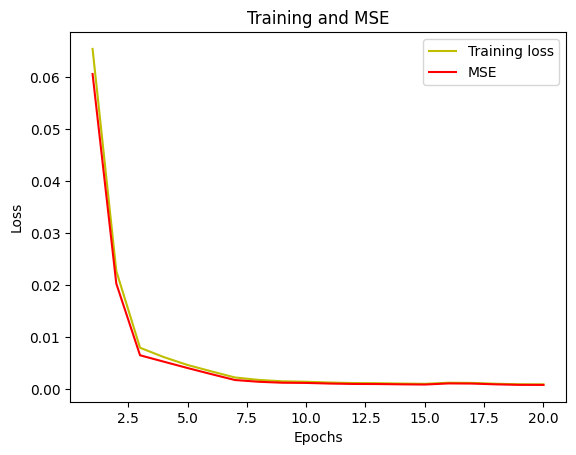

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
mse = history.history['mse']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, mse, 'r', label='MSE')
plt.title('Training and MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images

1/1 [==============================] - 1s 872ms/step


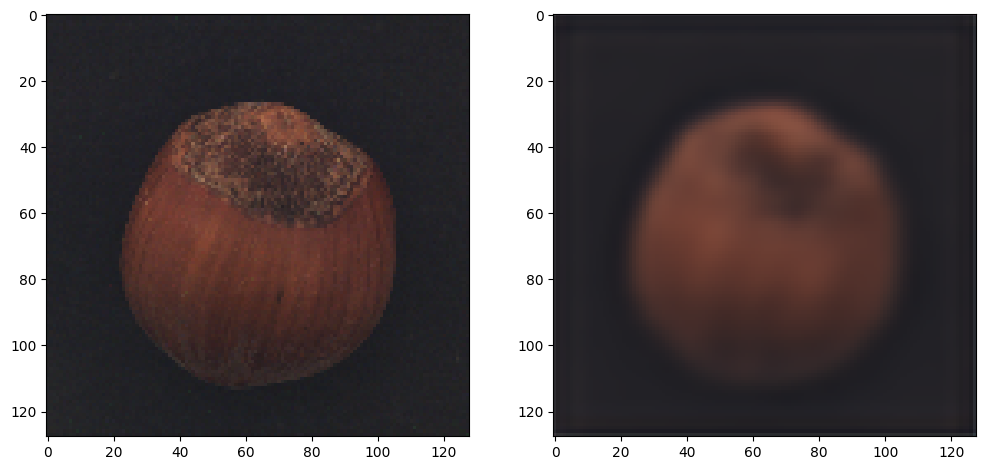

In [21]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [22]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

3/3 [==============================] - 3s 747ms/step - loss: 0.0020 - mse: 0.0019
Recon. error for the validation (normal) data is:  [0.0008604716276749969, 0.0007661017007194459]
Recon. error for the anomaly data is:  [0.002007728908210993, 0.0019001878099516034]


In [24]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()

encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3),  trainable=False, weights=model.layers[0].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same', strides=2))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', trainable=False, weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same', strides=2))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', trainable=False, weights=model.layers[4].get_weights()))

encoder_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
Total params: 14,768
Trainable params: 0
Non-trainable

In [26]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

c:\Users\AzqzPC\Desktop\Files\School\CIS490I\PaperReport\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


13/13 [==============================] - 11s 838ms/step


### Calculate Density & Recon Error to find the best threshold

In [27]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [ ]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

normal_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

print("Normal values: ", normal_values)
print("Anomaly values: ", anomaly_values)

In [29]:
#Now, input unknown images and sort as Good or Anomaly
# Also, display the images where the model predicts an anomaly

# Normal values:  (11307.173204610757, 0.00021034008735510042, 0.0010616554852364765, 0.0004691525145013336)
# Anomaly values:  (11281.388645922418, 18.430181872661812, 0.0022931333214435126, 0.00189302380217782)

density_threshold = 11300 #Set this value based on the above exercise
reconstruction_error_threshold = 0.0015 # Set this value based on the above exercise

def check_anomaly(img_path):
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.Resampling.LANCZOS))
    
    original_img = img.copy()
    
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    reconstruction_loss = np.abs(img - reconstruction)
    reconstruction_loss = np.mean(reconstruction_loss, axis=3)[0]
    
    return (density < density_threshold or reconstruction_error > reconstruction_error_threshold), original_img

### Sanity Check and testing the model

In [31]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
defective_file_paths = glob.glob('datasets/mvtecad/hazelnut/test/defective/**/*')
normal_file_paths = glob.glob('datasets/mvtecad/hazelnut/train/**/*')

tf.data.experimental.enable_debug_mode()

1/1 [==============================] - 0s 62ms/step - loss: 9.4286e-04 - mse: 8.3403e-04


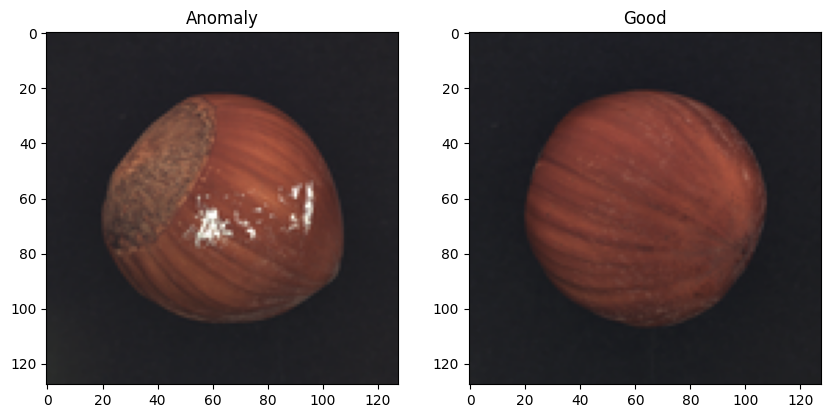

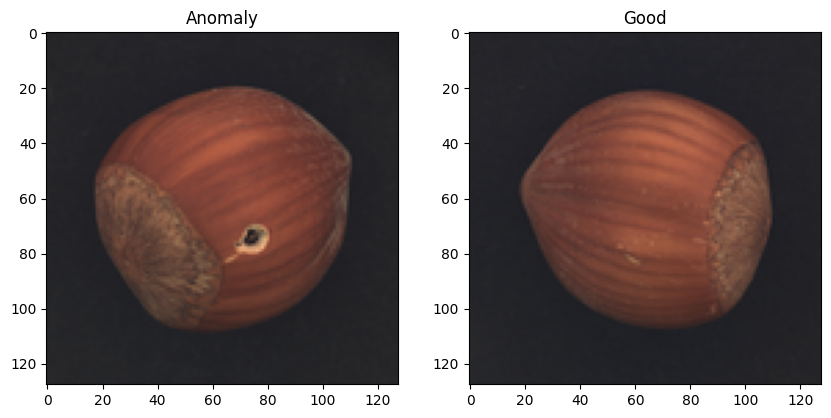

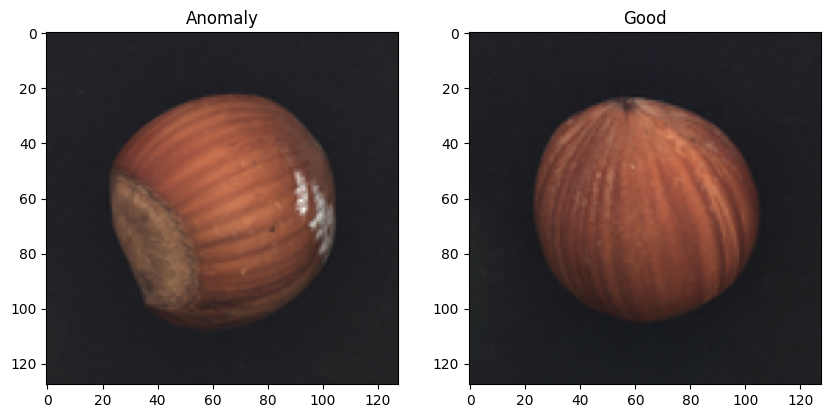

In [ ]:
for _ in range(3):
    # test images
    random_img = np.random.randint(0, len(defective_file_paths))
    is_anomaly, original_img = check_anomaly(defective_file_paths[random_img])

    random_img2 = np.random.randint(0, len(normal_file_paths))
    is_anomaly2, original_img2 = check_anomaly(normal_file_paths[random_img])

    fig, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].imshow(original_img)
    ax[0].set_title("Anomaly" if is_anomaly else "Good")
    
    # add an overlay 
    

    ax[1].imshow(original_img2)
    ax[1].set_title("Anomaly" if is_anomaly2 else "Good")

### Calculating the AUROC for the model

In [35]:
def roc_auc_score(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

def calc_auroc():
    y_true = []
    y_pred = []
    for f in defective_file_paths:
        is_anomaly, _ = check_anomaly(f)
        y_true.append(1)
        y_pred.append(is_anomaly)
        
    for f in normal_file_paths:
        is_anomaly, _ = check_anomaly(f)
        y_true.append(0)
        y_pred.append(is_anomaly)
        
    return roc_auc_score(y_true, y_pred)

print("AUROC: ", calc_auroc())

1/1 [==============================] - 0s 68ms/step - loss: 6.9095e-04 - mse: 5.8690e-04
AUROC:  0.9327548806941431


### Let's see if the model is able to localize the anomalies

In [127]:
reconstruction_error_threshold = 0.002

def check_anomaly_localization(img_path):
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.Resampling.LANCZOS))
    
    original_img = img.copy()
    
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    reconstruction_loss = np.abs(img - reconstruction)
    reconstruction_loss = np.mean(reconstruction_loss, axis=3)[0]
    
    # add a mask of the reconstruction loss as a heatmap
    
    mask = reconstruction_loss > 0.08
    overlay = original_img.copy()
    overlay[mask] = [0, 255, 0]
    
    
    return (density < density_threshold or reconstruction_error > reconstruction_error_threshold), original_img, overlay

1/1 [==============================] - 0s 68ms/step - loss: 8.7170e-04 - mse: 7.6878e-04


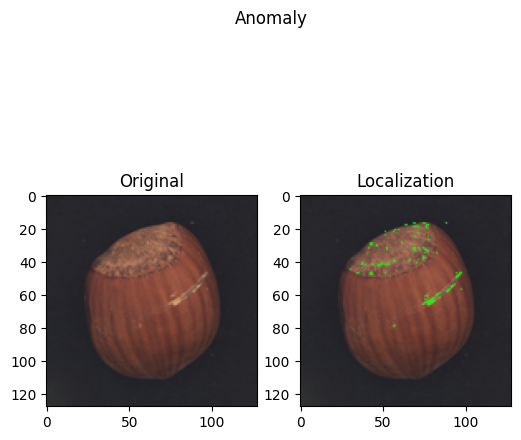

1/1 [==============================] - 0s 70ms/step - loss: 0.0054 - mse: 0.0053


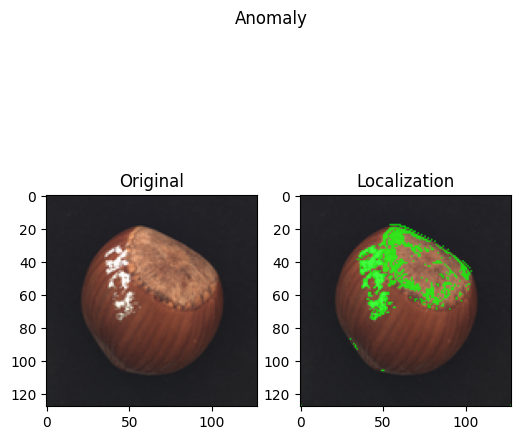

1/1 [==============================] - 0s 68ms/step - loss: 9.4004e-04 - mse: 8.3563e-04


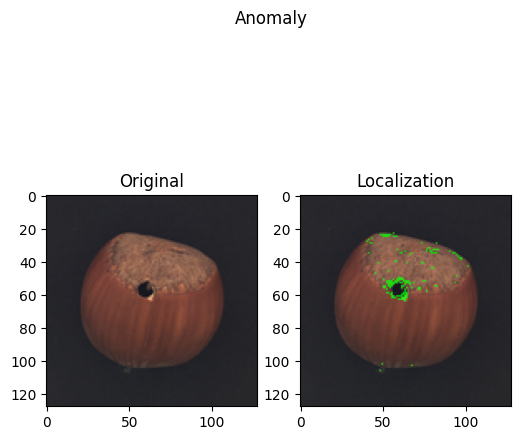

1/1 [==============================] - 0s 72ms/step - loss: 6.8866e-04 - mse: 5.8870e-04


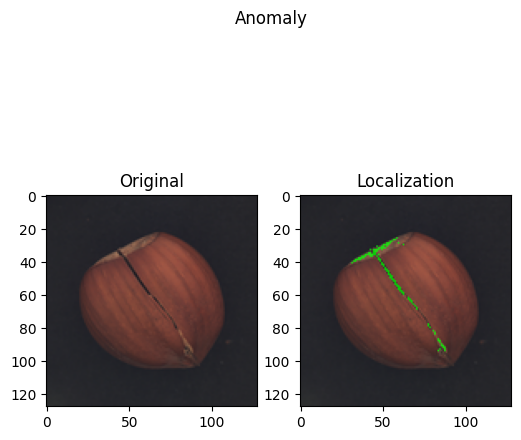

1/1 [==============================] - 0s 65ms/step - loss: 0.0010 - mse: 9.0599e-04


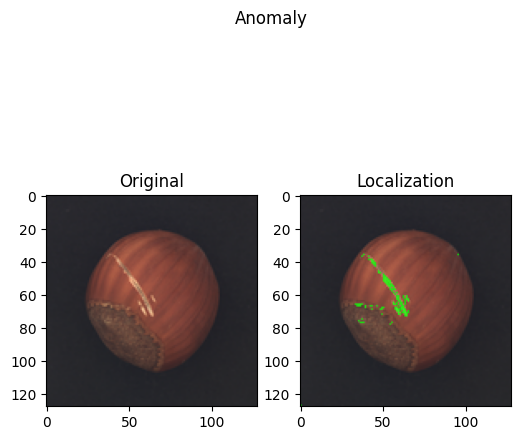

1/1 [==============================] - 0s 68ms/step - loss: 0.0010 - mse: 9.1588e-04


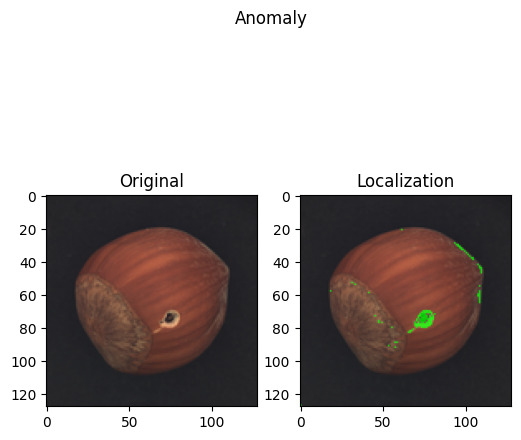

1/1 [==============================] - 0s 69ms/step - loss: 0.0012 - mse: 0.0010


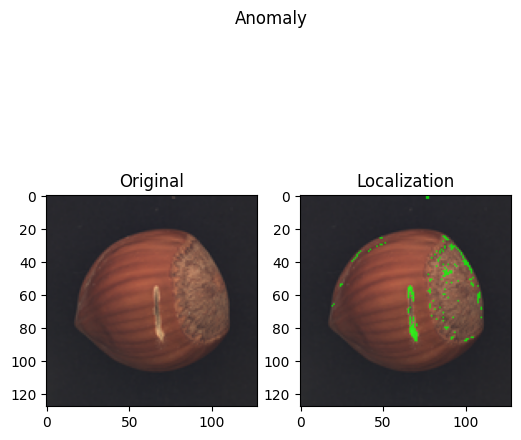

1/1 [==============================] - 0s 69ms/step - loss: 9.0469e-04 - mse: 7.9378e-04


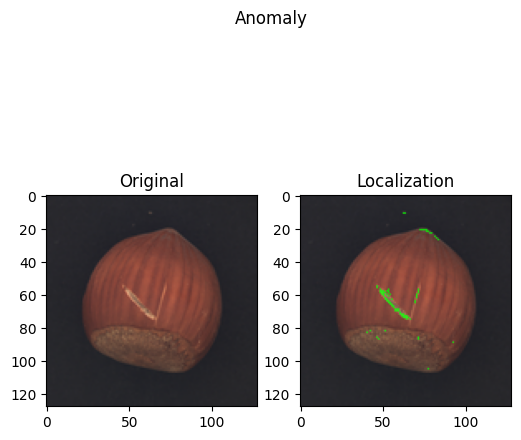

1/1 [==============================] - 0s 71ms/step - loss: 0.0044 - mse: 0.0043


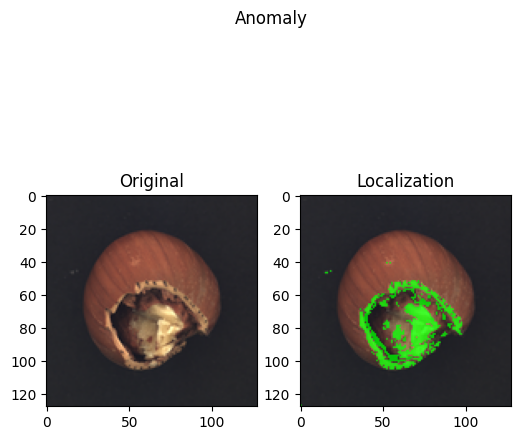

1/1 [==============================] - 0s 71ms/step - loss: 0.0011 - mse: 9.4081e-04


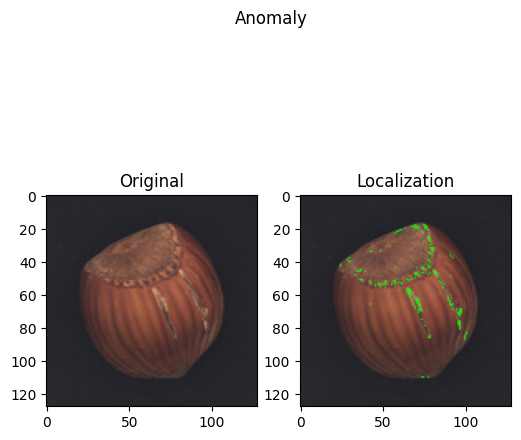

In [129]:

for _ in range(10):
    # test images
    random_img = np.random.randint(0, len(defective_file_paths))
    is_anomaly, original_img, mask = check_anomaly_localization(defective_file_paths[random_img])

    fig, ax = plt.subplots(1,2, figsize=(6,6))
    
    fig.suptitle("Anomaly" if is_anomaly else "Good")
    
    ax[0].imshow(original_img)
    ax[0].set_title("Original")
    
    ax[1].imshow(original_img)
    ax[1].imshow(mask, alpha=0.75, cmap='jet')
    ax[1].set_title("Localization")
    
    plt.show()

    

